# Comparing Fits and Parameters

Comparisons
- R2
    - GLMsingle vs pRF (temporal vs spatial)
    - Motion Energy vs pRF (nonlinearity)
- Location, size
    - Motion energy 
    - pRF 
- NRAs
    - GLMsingle forward
    - GLMsingle backward

In [46]:
import numpy as np
import pandas as pd
import yaml
from pathlib import Path
import argparse
import pickle
import os
import nibabel as nib
from matplotlib import pyplot as plt
from scipy.stats import linregress
from matplotlib.gridspec import GridSpec

from src import io_utils

subject = 2

# load config
config = io_utils.load_config()
DIR_DERIVATIVES = Path(config['paths']['derivatives'])

In [47]:
# load results
subject_str = f'sub-{str(subject).zfill(3)}'
subject_dir = DIR_DERIVATIVES / subject_str

prf_params = pd.read_csv(subject_dir / 'prf_analysis' / f'{subject_str}_norm_test_fit.csv')
moten_params = pd.read_csv(subject_dir / 'moten_analysis_aot_fw' / f'{subject_str}_params.csv')

# r2
aot_r2 = nib.load(subject_dir
         / 'GLMsingle_analysis'
         / f'{subject_str}_R2_aot_median.nii.gz').get_fdata()
aot_diff_r2 = nib.load(subject_dir
         / 'GLMsingle_analysis'
         / f'{subject_str}_R2_diff_median.nii.gz').get_fdata()


-22396918643.557148 92.89717279983604
0.00016718107603175023


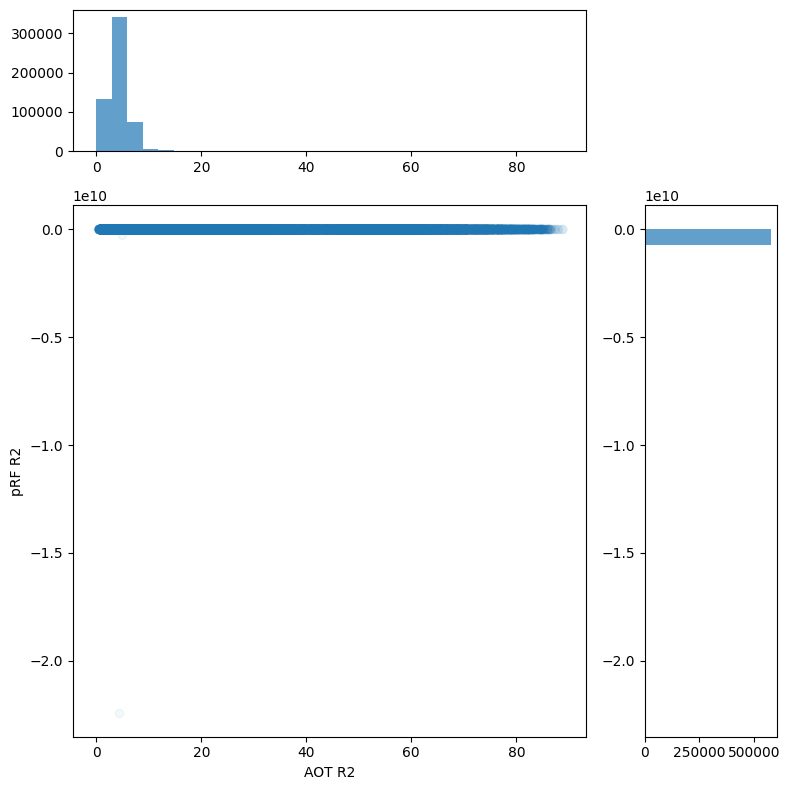

0.0 92.89717279983604
0.6254700048001304


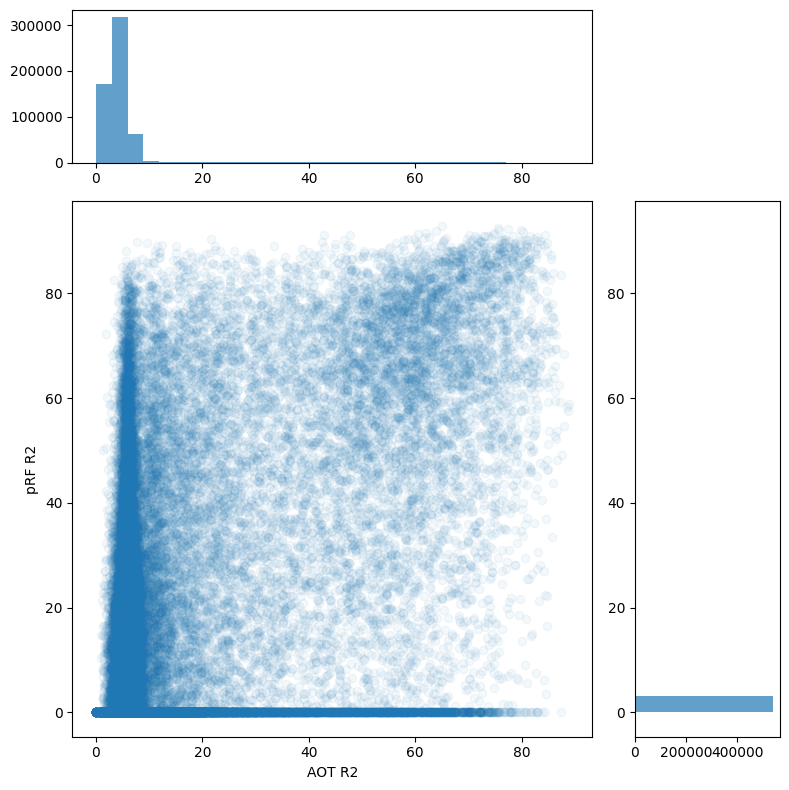

In [48]:

def plot_scatter(xdata, ydata, xlabel, ylabel = 'pRF R2', xlims = None, ylims = None, alpha = .05, fit_line=False, diag_line=False):
    fig = plt.figure(figsize=(8, 8))
    gs = GridSpec(4, 4)
    
    ax_main = fig.add_subplot(gs[1:4, 0:3])
    ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
    ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
    
    ax_main.scatter(xdata, ydata, alpha=alpha)
    ax_main.set_xlabel(xlabel)
    ax_main.set_ylabel(ylabel)

    combined = np.concatenate((xdata, ydata))
    minval = np.nanmin(combined)
    maxval = np.nanmax(combined)
    print(minval, maxval)

    if diag_line:
        diag_line = np.linspace(minval, maxval, 10)
        ax_main.plot(diag_line, diag_line, color='black', linestyle='--')

    xdata = np.nan_to_num(xdata)
    ydata = np.nan_to_num(ydata)
    slope, intercept, r_value, p_value, std_err = linregress(xdata, ydata)
    print(r_value)
    if fit_line:
        fitted_line = slope * xdata + intercept
        ax_main.plot(xdata, fitted_line, color='red', label=f'r = {r_value:.2f}')
        ax_main.legend()


    if xlims:
        ax_main.set_xlim(xlims)
    if ylims:
        ax_main.set_ylim(ylims)


    ax_histx.hist(xdata, bins=30, alpha=0.7)
    ax_histy.hist(ydata, bins=30, orientation='horizontal', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

aot_r2 = aot_r2.flatten()
prf_r2 = prf_params['r2'] * 100
plot_scatter(aot_r2, prf_r2, xlabel = 'AOT R2')

# settings negatives to 0
negatives = prf_r2 < 0
aot_r2[negatives] = 0
prf_r2[negatives] = 0
plot_scatter(aot_r2, prf_r2,  xlabel = 'AOT R2')


-26.011333332307867 92.89717279983604
0.11789528279045544


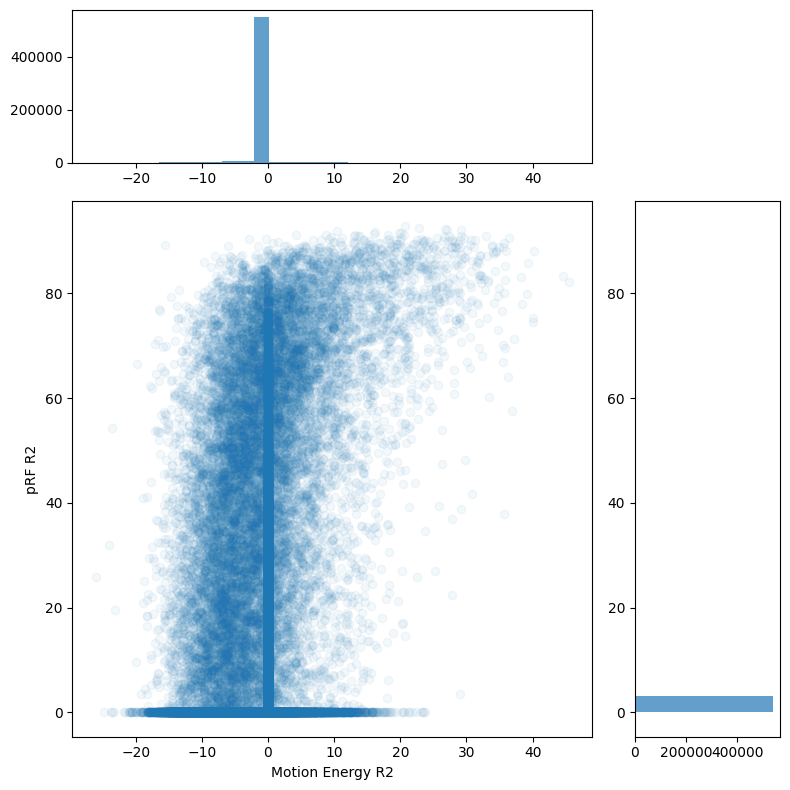

In [49]:
moten_r2 = moten_params['R2'] * 100
plot_scatter(moten_r2, prf_r2,  xlabel = 'Motion Energy R2')


# Location


In [50]:
moten_params.iloc[:,:]

,centerh,centerv,direction,spatial_freq,spatial_env,temporal_freq,temporal_env,filter_temporal_width,aspect_ratio,stimulus_fps,spatial_phase_offset,ecc,polar,R2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
574652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
574653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
574654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
print(np.nanmin(moten_params['R2']),
np.nanmax(moten_params['R2'])
)

-0.2601133333230787 0.4546477503081855


In [52]:
rsq_threshold_moten = 0.05
rsq_threshold_prf = 0.8
include_vertices = (moten_params['R2'] > rsq_threshold_moten) & (prf_params['r2'] > rsq_threshold_prf)
include_vertices = include_vertices & (moten_params['ecc'] > 0) & (moten_params['ecc'] < 10) 

0.0054499742482201 8.969000083424204
0.4277239329207757


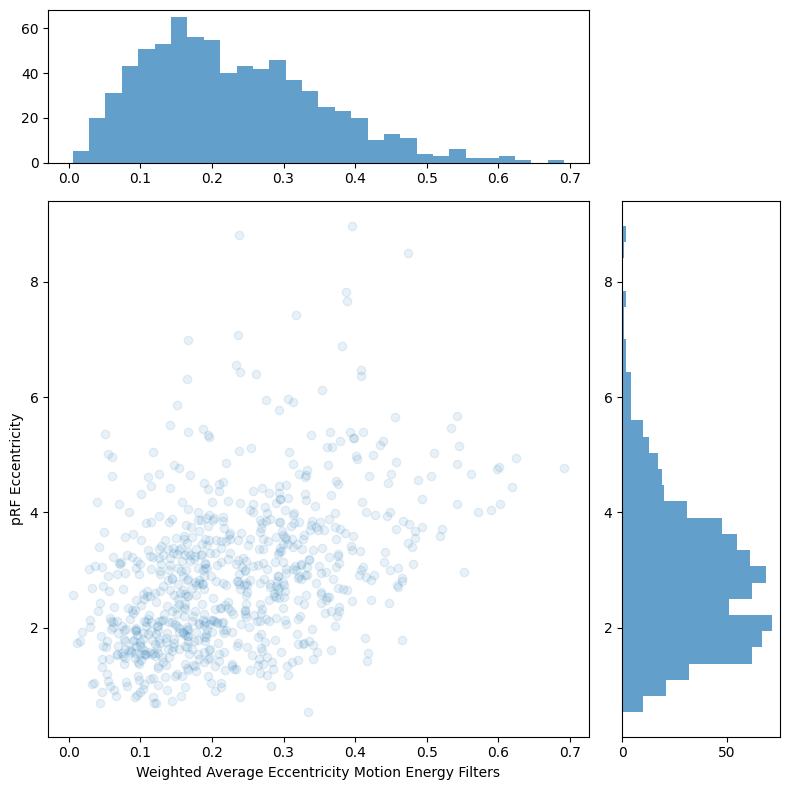

0.0054499742482201 8.969000083424204
0.4277239329207757


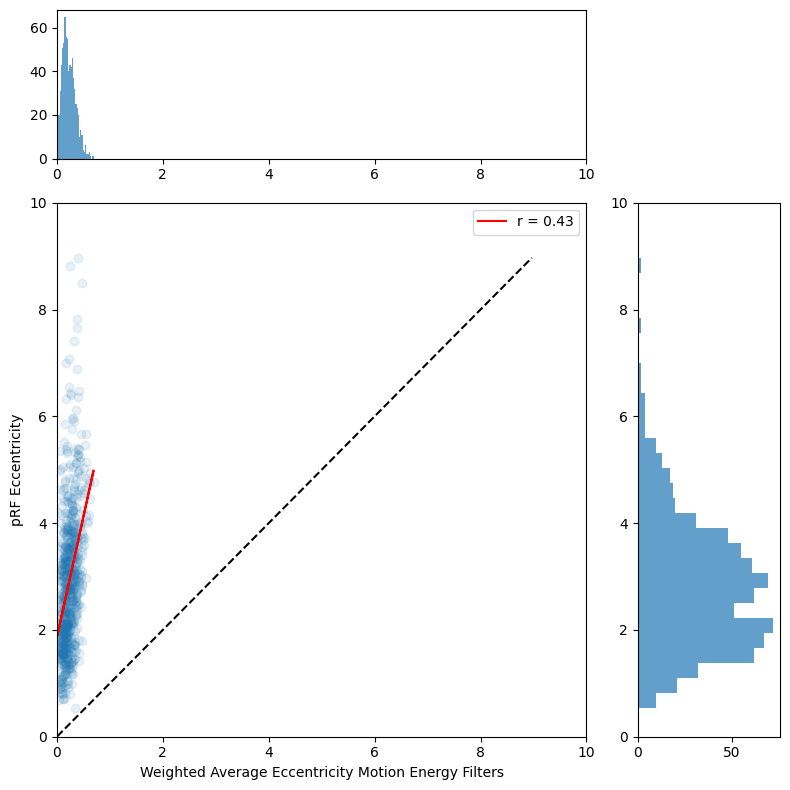

In [53]:
moten_ecc = moten_params.loc[include_vertices, 'ecc']
prf_ecc = prf_params.loc[include_vertices, 'ecc']


xlabel = 'Weighted Average Eccentricity Motion Energy Filters'
plot_scatter(moten_ecc, prf_ecc, xlabel = xlabel, ylabel='pRF Eccentricity', alpha=.1)

lims = (0, 10)
plot_scatter(moten_ecc, prf_ecc, xlabel = xlabel, ylabel='pRF Eccentricity', alpha=.1, xlims=lims, ylims=lims, fit_line=True, diag_line=True)

-3.1403623147506123 3.138165856598321
0.6474769127885932


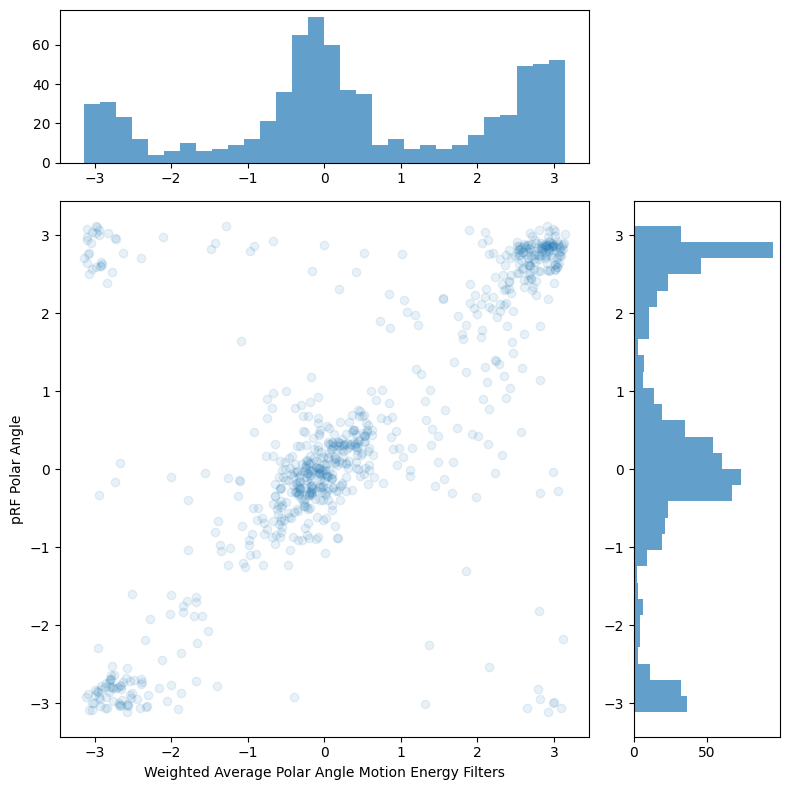

-3.1403623147506123 3.138165856598321
0.6474769127885932


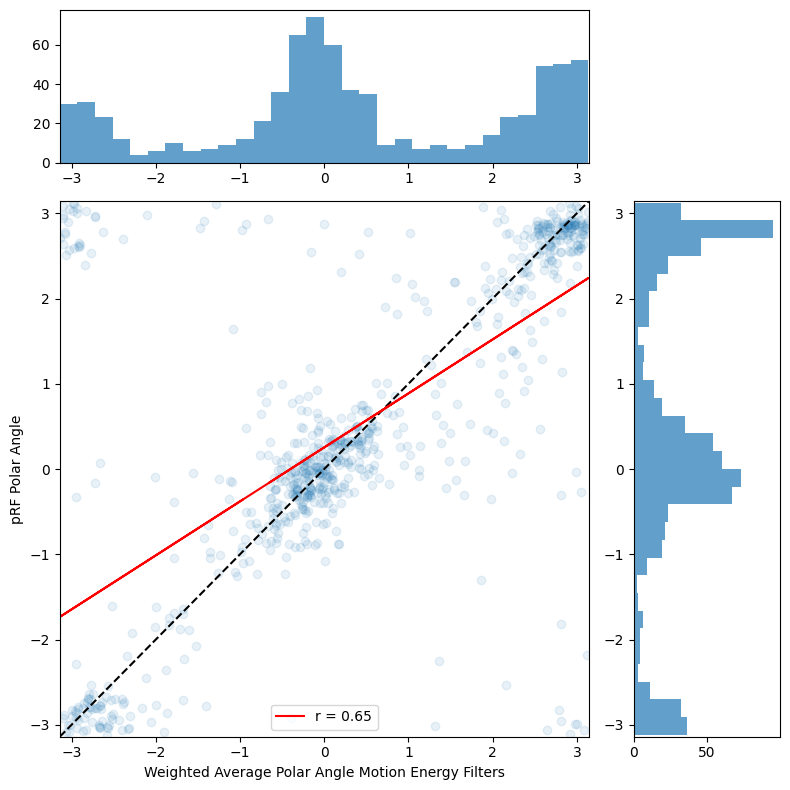

In [45]:
# include_vertices = include_vertices & (moten_params['polar'] > -3.142) & (moten_params['polar'] < 3.142)

prf_polar = prf_params.loc[include_vertices, 'polar']
moten_polar = moten_params.loc[include_vertices, 'polar']
# moten_polar[moten_polar < -3.142] = 0.0
# moten_polar[moten_polar > 3.142] = 0.0

xlabel = 'Weighted Average Polar Angle Motion Energy Filters'
plot_scatter(moten_polar, prf_polar, xlabel = xlabel, ylabel='pRF Polar Angle', alpha=.1)

xlims = (-3.14, 3.14) #(-5, )
ylims = (-3.14, 3.14)
plot_scatter(moten_polar, prf_polar, xlabel = xlabel, ylabel='pRF Polar Angle', alpha=.1, xlims=xlims, ylims=ylims, diag_line=True, fit_line=True)


# Prediction Errors

In [ ]:
glmsingle_betas_aot = np.load(subject_dir / 'ses-01' / 'GLMsingle_aot' / 'TYPED_FITHRF_GLMDENOISE_RR.npy', allow_pickle=True).item()['betasmd']
# glmsingle_betas_control = np.load(subject_dir / 'ses-01' / 'GLMsingle_control' / 'TYPED_FITHRF_GLMDENOISE_RR.npy', allow_pickle=True).item()['betasmd']



In [ ]:
print(glmsingle_betas_aot.shape)#, glmsingle_betas_control.shape)

(73, 96, 82, 720) (73, 96, 82, 720)
